In [103]:
!pip install torch torchvision wandb

In [96]:
# Standard libraries
import numpy as np
import matplotlib.pyplot as plt

# PyTorch imports
import torch
from torch import nn
import torch.nn.functional as F

# torchvision imports
from torchvision import datasets
from torchvision.transforms import v2
from torchvision.transforms import Lambda
from torch.utils.data import random_split

# Other libraries
from sklearn.metrics import f1_score
from rich import print

In [105]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### Downloading and transforming the data

In [64]:
# Defining the transformation for the input feaures and target labels
feature_transform = v2.Compose([
    v2.Resize(size=(32, 32), antialias=True),  # Resize all images to 32x32
    v2.Grayscale(num_output_channels=1),  # Convert to grayscale (1 channel)
    v2.ToImage(),  # Convert PIL or numpy array to tensor
    v2.ToDtype(torch.float32, scale=True),  # Scale to [0, 1] and convert to float
    v2.Normalize(mean=[0.485], std=[0.229]),  # Normalize for grayscale (single channel)
])

target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

In [65]:
# Load the MNIST training dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=feature_transform,target_transform=target_transform)

# Load the MNIST test dataset
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=feature_transform,target_transform=target_transform)

In [66]:
# Get the image tensor from the dataset
img, label = train_dataset[0]

# Check the shape (dimensions) of the image
print("Image Shape:", img.shape)

Image Shape:
torch.Size([1, 32, 32])

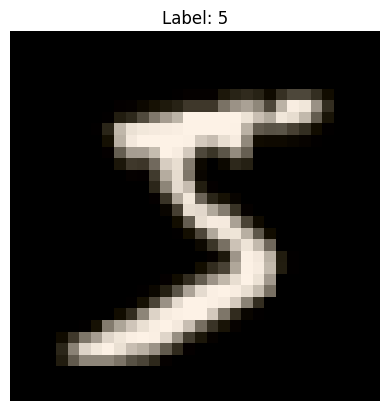

In [67]:
def visualize_image(dataset, index):
    """
    Visualizes an image from the dataset at the given index, along with its label.

    Args:
    - dataset (torch.utils.data.Dataset): The dataset containing images and labels.
    - index (int): The index of the image in the dataset to visualize.
    """
    # Extract the image and label
    img, label = dataset[index]

    # The image tensor is of shape [C, H, W], so we need to permute it to [H, W, C]
    img = img.permute(1, 2, 0).numpy()

    # Reverse normalization (assuming the image was normalized using these means and stds)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Undo the normalization by multiplying by the standard deviation and adding the mean
    img = img * std + mean

    # Clip the values to be in the range [0, 1] (to avoid any overflows after undoing the normalization)
    img = np.clip(img, 0, 1)

    # Display the image
    plt.imshow(img)
    plt.title(f'Label: {torch.argmax(label).item()}')  # Display label
    plt.axis('off')  # Hide axes for a cleaner display
    plt.show()

visualize_image(train_dataset, 0)

### Loading the data into data loaders

In [97]:
# Define the split ratio for training and validation datasets (e.g., 80% train, 20% validation)
train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size   # Remaining 20% for validation

# Split the train dataset into training and validation
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

# Create DataLoader for training, validation, and testing datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)  # No shuffle for validation
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# Print the sizes of the datasets
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
print(f'Test dataset size: {len(test_dataset)}')

Train dataset size: 48000

Validation dataset size: 12000

Test dataset size: 10000

### Defining the LeNet Model
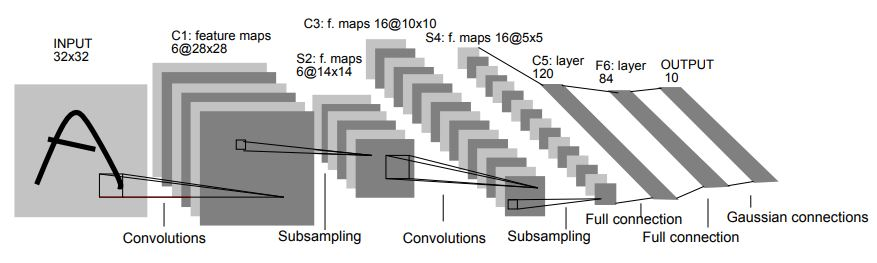

In [69]:
# Let's setup the device for the training
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device

In [70]:
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.avg_pool2d(F.relu(self.conv1(x)), kernel_size=2, stride=2)
        x = F.avg_pool2d(F.relu(self.conv2(x)), kernel_size=2, stride=2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [115]:
model = LeNet5().to(device)
print(model)

LeNet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [72]:
# Sending the image as batch,chanells,height,width
X = torch.rand(1,1,32,32, device=device)
logits = model(X)
pred_probab = nn.Softmax(dim=1)(logits)
y_pred = pred_probab.argmax(1)
print(f"Predicted class: {y_pred}")

Predicted class: tensor([3], device='cuda:0')

### Defining the early stopping class

In [98]:
# Early stopping class
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience  # Number of epochs to wait for improvement
        self.min_delta = min_delta  # Minimum change to qualify as an improvement
        self.counter = 0  # Counter for how many epochs since the last improvement
        self.best_loss = float('inf')  # Initialize with a large value
        self.early_stop = False  # Flag to indicate if we should stop early
        self.best_model_wts = None  # To save the best model weights

    def __call__(self, val_loss, model):
        # Check if validation loss improved
        if self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_wts = model.state_dict()  # Save the best model weights
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def load_best_model(self, model):
        # Load the best model weights
        model.load_state_dict(self.best_model_wts)

### Defining the hyper parameters

In [116]:
learning_rate = 1e-3
batch_size = 128
epochs = 100
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [117]:
# Initialize WandB to track the experiment
wandb.init(
    project="network_implementations",  # Project name in WandB
    config={
        "learning_rate": 0.001,  # Learning rate for the optimizer
        "batch_size": 128,       # Batch size for the data loader
        "epochs": 100,            # Total number of epochs to train
        "optimizer": "Stochastic Gradient Descent (SGD)",     # Optimizer being used
        "model_name": "LeNet",   # Model architecture name
        "train_dataset_size": len(train_loader)*128,  # Size of the training dataset
        "test_dataset_size": len(test_loader)*128,    # Size of the test dataset
        "validation_dataset_size": len(val_loader)*128,    # Size of the test dataset
        "device": device,   # Device being used (cuda or cpu)
    },reinit=True
)

epoch,▁▁▁▁▁▁▁▂▂▂▂▂▂▂▄▄▄▄▄▄▄▅▅▅▅▅▅▅▇▇▇▇▇▇██████
step,▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█▁▃▆█
test_accuracy,▅▆▁▅█
test_f1_score,▅▆▁▅█
test_loss,▅▇█▂▁
train_f1_score,▁▂▃▅█▇
train_loss,█▃▃▁▁▂▄▄▂▄▂▅▆▂▁▂▃▅▄▄▆▆▂▁
validation_accuracy,▂▄▁▃▃█
validation_loss,▇▆█▆▄▁
epoch,5
step,38400


### Defining the training and test loops

In [118]:
# Training loop with early stopping
def train_loop(dataloader, model, loss_fn, optimizer, val_loader, epoch, early_stopping=None):
    size = len(dataloader.dataset)
    model.train()  # Set model to training mode

    all_preds = []  # List to store predictions
    all_labels = []  # List to store true labels

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # If the labels are one-hot encoded, convert them to class indices
        if y.ndimension() > 1:  # If y is one-hot encoded
            y = y.argmax(1)  # Convert to class indices

        # Compute prediction and loss
        logits = model(X)  # Forward pass
        loss = loss_fn(logits, y)  # Loss function (no Softmax needed)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Store predictions and labels
        all_preds.extend(logits.argmax(1).cpu().numpy())  # Get predicted class indices
        all_labels.extend(y.cpu().numpy())  # Get true class indices

        # Log the loss to WandB
        if batch % 100 == 0:
            loss_value = loss.item()
            current = batch * len(X)
            print(f"loss: {loss_value:>7f}  [{current:>5d}/{size:>5d}]")
            wandb.log({
                "train_loss": loss_value,
                "epoch": epoch,
                "step": current,
            })

    # Compute F1 score after the epoch
    train_f1 = f1_score(all_labels, all_preds, average='weighted')  # Weighted average for multi-class
    print(f"Training F1 Score: {train_f1:.4f}")

    # Log the training F1 score
    wandb.log({"train_f1_score": train_f1, "epoch": epoch})

    # Evaluate validation loss for early stopping
    if early_stopping:
        val_loss = evaluate_validation_loss(model, loss_fn, val_loader)
        wandb.log({"validation_loss": val_loss, "epoch": epoch})
        early_stopping(val_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            early_stopping.load_best_model(model)
            return True  # Stop training early
    return False

# Validation loss evaluation for early stopping
def evaluate_validation_loss(model, loss_fn, val_loader):
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            # If the labels are one-hot encoded, convert them to class indices
            if y.ndimension() > 1:
                y = y.argmax(1)

            # Compute prediction and loss
            logits = model(X)
            val_loss += loss_fn(logits, y).item()

            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

    val_loss /= len(val_loader)
    accuracy = 100 * correct / len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%")

    # Log validation accuracy and loss to WandB
    wandb.log({"validation_accuracy": accuracy, "epoch": epoch})

    return val_loss

# Test loop for model evaluation
def test_loop(dataloader, model, loss_fn, epoch):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_preds = []  # List to store predictions
    all_labels = []  # List to store true labels

    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            # If the labels are one-hot encoded, convert them to class indices
            if y.ndimension() > 1:
                y = y.argmax(1)

            # Compute prediction and loss
            logits = model(X)
            test_loss += loss_fn(logits, y).item()

            # Store predictions and labels
            all_preds.extend(logits.argmax(1).cpu().numpy())
            all_labels.extend(y.cpu().numpy())

            correct += (logits.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = 100 * correct / size

    # Compute F1 score on validation/test set
    test_f1 = f1_score(all_labels, all_preds, average='weighted')

    # Log the test accuracy, loss, and F1 score to WandB
    wandb.log({
        "test_accuracy": accuracy,
        "test_loss": test_loss,
        "test_f1_score": test_f1,
        "epoch": epoch
    })

    print(f"Test Error: \n Accuracy: {accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Test F1 Score: {test_f1:.4f}")

### Trainig the network

In [119]:
# Set the patience for early stopping
early_stopping = EarlyStopping(patience=5, min_delta=0.01)

# Training loop with early stopping
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    # Train the model
    stop_early = train_loop(train_loader, model, loss_fn, optimizer, val_loader, epoch, early_stopping)

    if stop_early:
        break  # Stop training early if early stopping was triggered

    # Test the model after each epoch
    test_loop(test_loader, model, loss_fn, epoch)


Epoch 1/100

loss: 2.302189  [    0/48000]

loss: 2.299683  [12800/48000]

loss: 2.295621  [25600/48000]

loss: 2.299047  [38400/48000]

Training F1 Score: 0.0569

Validation Loss: 2.2986, Accuracy: 18.37%

Test Error: 
 Accuracy: 18.5%, Avg loss: 2.297649

Test F1 Score: 0.0738

Epoch 2/100

loss: 2.288992  [    0/48000]

loss: 2.304162  [12800/48000]

loss: 2.299431  [25600/48000]

loss: 2.288118  [38400/48000]

Training F1 Score: 0.0594

Validation Loss: 2.2918, Accuracy: 14.16%

Test Error: 
 Accuracy: 14.6%, Avg loss: 2.290695

Test F1 Score: 0.0553

Epoch 3/100

loss: 2.291299  [    0/48000]

loss: 2.283854  [12800/48000]

loss: 2.284445  [25600/48000]

loss: 2.278081  [38400/48000]

Training F1 Score: 0.0419

Validation Loss: 2.2814, Accuracy: 12.03%

Test Error: 
 Accuracy: 12.3%, Avg loss: 2.280227

Test F1 Score: 0.0380

Epoch 4/100

loss: 2.287127  [    0/48000]

loss: 2.269665  [12800/48000]

loss: 2.277521  [25600/48000]

loss: 2.264482  [38400/48000]

Training F1 Score: 0.0292

Validation Loss: 2.2627, Accuracy: 11.56%

Test Error: 
 Accuracy: 11.8%, Avg loss: 2.261105

Test F1 Score: 0.0311

Epoch 5/100

loss: 2.259267  [    0/48000]

loss: 2.252266  [12800/48000]

loss: 2.247921  [25600/48000]

loss: 2.243580  [38400/48000]

Training F1 Score: 0.0275

Validation Loss: 2.2291, Accuracy: 11.80%

Test Error: 
 Accuracy: 11.9%, Avg loss: 2.226739

Test F1 Score: 0.0343

Epoch 6/100

loss: 2.226318  [    0/48000]

loss: 2.234377  [12800/48000]

loss: 2.230760  [25600/48000]

loss: 2.170479  [38400/48000]

Training F1 Score: 0.0764

Validation Loss: 2.1532, Accuracy: 19.92%

Test Error: 
 Accuracy: 20.5%, Avg loss: 2.147946

Test F1 Score: 0.1601

Epoch 7/100

loss: 2.147201  [    0/48000]

loss: 2.119819  [12800/48000]

loss: 2.113950  [25600/48000]

loss: 2.014976  [38400/48000]

Training F1 Score: 0.2654

Validation Loss: 1.9497, Accuracy: 40.22%

Test Error: 
 Accuracy: 41.8%, Avg loss: 1.937577

Test F1 Score: 0.3738

Epoch 8/100

loss: 1.959724  [    0/48000]

loss: 1.806889  [12800/48000]

loss: 1.715807  [25600/48000]

loss: 1.443518  [38400/48000]

Training F1 Score: 0.5040

Validation Loss: 1.3852, Accuracy: 64.86%

Test Error: 
 Accuracy: 67.1%, Avg loss: 1.359794

Test F1 Score: 0.6520

Epoch 9/100

loss: 1.319076  [    0/48000]

loss: 1.149040  [12800/48000]

loss: 0.925231  [25600/48000]

loss: 0.865413  [38400/48000]

Training F1 Score: 0.7167

Validation Loss: 0.8485, Accuracy: 76.53%

Test Error: 
 Accuracy: 77.4%, Avg loss: 0.820128

Test F1 Score: 0.7699

Epoch 10/100

loss: 0.836501  [    0/48000]

loss: 0.719074  [12800/48000]

loss: 0.707939  [25600/48000]

loss: 0.602763  [38400/48000]

Training F1 Score: 0.7877

Validation Loss: 0.6602, Accuracy: 79.88%

Test Error: 
 Accuracy: 81.3%, Avg loss: 0.631501

Test F1 Score: 0.8107

Epoch 11/100

loss: 0.644823  [    0/48000]

loss: 0.635240  [12800/48000]

loss: 0.557557  [25600/48000]

loss: 0.617665  [38400/48000]

Training F1 Score: 0.8187

Validation Loss: 0.5672, Accuracy: 83.20%

Test Error: 
 Accuracy: 83.6%, Avg loss: 0.545570

Test F1 Score: 0.8353

Epoch 12/100

loss: 0.511089  [    0/48000]

loss: 0.426261  [12800/48000]

loss: 0.422162  [25600/48000]

loss: 0.532747  [38400/48000]

Training F1 Score: 0.8395

Validation Loss: 0.5142, Accuracy: 84.73%

Test Error: 
 Accuracy: 85.1%, Avg loss: 0.498328

Test F1 Score: 0.8514

Epoch 13/100

loss: 0.677030  [    0/48000]

loss: 0.431587  [12800/48000]

loss: 0.388315  [25600/48000]

loss: 0.473542  [38400/48000]

Training F1 Score: 0.8528

Validation Loss: 0.4765, Accuracy: 85.69%

Test Error: 
 Accuracy: 86.3%, Avg loss: 0.456647

Test F1 Score: 0.8623

Epoch 14/100

loss: 0.460755  [    0/48000]

loss: 0.557499  [12800/48000]

loss: 0.417698  [25600/48000]

loss: 0.353793  [38400/48000]

Training F1 Score: 0.8616

Validation Loss: 0.4501, Accuracy: 86.66%

Test Error: 
 Accuracy: 87.1%, Avg loss: 0.432448

Test F1 Score: 0.8706

Epoch 15/100

loss: 0.448239  [    0/48000]

loss: 0.533036  [12800/48000]

loss: 0.441342  [25600/48000]

loss: 0.316376  [38400/48000]

Training F1 Score: 0.8679

Validation Loss: 0.4269, Accuracy: 87.03%

Test Error: 
 Accuracy: 87.6%, Avg loss: 0.406511

Test F1 Score: 0.8754

Epoch 16/100

loss: 0.318055  [    0/48000]

loss: 0.379716  [12800/48000]

loss: 0.394506  [25600/48000]

loss: 0.533075  [38400/48000]

Training F1 Score: 0.8734

Validation Loss: 0.4112, Accuracy: 87.63%

Test Error: 
 Accuracy: 88.1%, Avg loss: 0.391674

Test F1 Score: 0.8806

Epoch 17/100

loss: 0.300110  [    0/48000]

loss: 0.351177  [12800/48000]

loss: 0.479544  [25600/48000]

loss: 0.365268  [38400/48000]

Training F1 Score: 0.8789

Validation Loss: 0.3977, Accuracy: 88.05%

Test Error: 
 Accuracy: 88.3%, Avg loss: 0.380126

Test F1 Score: 0.8825

Epoch 18/100

loss: 0.265904  [    0/48000]

loss: 0.280064  [12800/48000]

loss: 0.332404  [25600/48000]

loss: 0.464474  [38400/48000]

Training F1 Score: 0.8821

Validation Loss: 0.3875, Accuracy: 88.25%

Test Error: 
 Accuracy: 88.8%, Avg loss: 0.365233

Test F1 Score: 0.8874

Epoch 19/100

loss: 0.303999  [    0/48000]

loss: 0.317984  [12800/48000]

loss: 0.472090  [25600/48000]

loss: 0.444677  [38400/48000]

Training F1 Score: 0.8843

Validation Loss: 0.3775, Accuracy: 88.44%

Test Error: 
 Accuracy: 89.4%, Avg loss: 0.352786

Test F1 Score: 0.8935

Epoch 20/100

loss: 0.509540  [    0/48000]

loss: 0.358052  [12800/48000]

loss: 0.320374  [25600/48000]

loss: 0.294962  [38400/48000]

Training F1 Score: 0.8874

Validation Loss: 0.3637, Accuracy: 88.93%

Test Error: 
 Accuracy: 89.4%, Avg loss: 0.342792

Test F1 Score: 0.8941

Epoch 21/100

loss: 0.437824  [    0/48000]

loss: 0.289819  [12800/48000]

loss: 0.531741  [25600/48000]

loss: 0.310107  [38400/48000]

Training F1 Score: 0.8896

Validation Loss: 0.3583, Accuracy: 89.02%

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.334062

Test F1 Score: 0.8987

Epoch 22/100

loss: 0.434650  [    0/48000]

loss: 0.275277  [12800/48000]

loss: 0.366812  [25600/48000]

loss: 0.279545  [38400/48000]

Training F1 Score: 0.8921

Validation Loss: 0.3489, Accuracy: 89.33%

Test Error: 
 Accuracy: 90.1%, Avg loss: 0.325192

Test F1 Score: 0.9007

Epoch 23/100

loss: 0.507351  [    0/48000]

loss: 0.177749  [12800/48000]

loss: 0.381505  [25600/48000]

loss: 0.338273  [38400/48000]

Training F1 Score: 0.8954

Validation Loss: 0.3467, Accuracy: 89.60%

Test Error: 
 Accuracy: 89.9%, Avg loss: 0.328078

Test F1 Score: 0.8990

Epoch 24/100

loss: 0.306930  [    0/48000]

loss: 0.268231  [12800/48000]

loss: 0.323475  [25600/48000]

loss: 0.403125  [38400/48000]

Training F1 Score: 0.8975

Validation Loss: 0.3332, Accuracy: 89.81%

Test Error: 
 Accuracy: 90.5%, Avg loss: 0.313448

Test F1 Score: 0.9043

Epoch 25/100

loss: 0.272633  [    0/48000]

loss: 0.273877  [12800/48000]

loss: 0.368226  [25600/48000]

loss: 0.335504  [38400/48000]

Training F1 Score: 0.8996

Validation Loss: 0.3301, Accuracy: 90.02%

Test Error: 
 Accuracy: 90.8%, Avg loss: 0.309651

Test F1 Score: 0.9080

Epoch 26/100

loss: 0.377543  [    0/48000]

loss: 0.310078  [12800/48000]

loss: 0.321114  [25600/48000]

loss: 0.326633  [38400/48000]

Training F1 Score: 0.9016

Validation Loss: 0.3219, Accuracy: 90.13%

Test Error: 
 Accuracy: 90.9%, Avg loss: 0.302010

Test F1 Score: 0.9091

Epoch 27/100

loss: 0.380096  [    0/48000]

loss: 0.337397  [12800/48000]

loss: 0.404767  [25600/48000]

loss: 0.285530  [38400/48000]

Training F1 Score: 0.9030

Validation Loss: 0.3139, Accuracy: 90.39%

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.293598

Test F1 Score: 0.9118

Epoch 28/100

loss: 0.303368  [    0/48000]

loss: 0.401709  [12800/48000]

loss: 0.369990  [25600/48000]

loss: 0.247055  [38400/48000]

Training F1 Score: 0.9053

Validation Loss: 0.3089, Accuracy: 90.47%

Test Error: 
 Accuracy: 91.1%, Avg loss: 0.287437

Test F1 Score: 0.9109

Epoch 29/100

loss: 0.251275  [    0/48000]

loss: 0.301317  [12800/48000]

loss: 0.206062  [25600/48000]

loss: 0.275485  [38400/48000]

Training F1 Score: 0.9071

Validation Loss: 0.3034, Accuracy: 90.48%

Test Error: 
 Accuracy: 91.5%, Avg loss: 0.281597

Test F1 Score: 0.9145

Epoch 30/100

loss: 0.365324  [    0/48000]

loss: 0.228084  [12800/48000]

loss: 0.405707  [25600/48000]

loss: 0.256302  [38400/48000]

Training F1 Score: 0.9091

Validation Loss: 0.2999, Accuracy: 90.92%

Test Error: 
 Accuracy: 91.2%, Avg loss: 0.282712

Test F1 Score: 0.9119

Epoch 31/100

loss: 0.367132  [    0/48000]

loss: 0.319291  [12800/48000]

loss: 0.294899  [25600/48000]

loss: 0.321648  [38400/48000]

Training F1 Score: 0.9106

Validation Loss: 0.2927, Accuracy: 90.87%

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.272821

Test F1 Score: 0.9170

Epoch 32/100

loss: 0.245693  [    0/48000]

loss: 0.272790  [12800/48000]

loss: 0.270128  [25600/48000]

loss: 0.253067  [38400/48000]

Training F1 Score: 0.9130

Validation Loss: 0.2935, Accuracy: 90.96%

Test Error: 
 Accuracy: 91.8%, Avg loss: 0.268953

Test F1 Score: 0.9181

Epoch 33/100

loss: 0.282803  [    0/48000]

loss: 0.284106  [12800/48000]

loss: 0.275768  [25600/48000]

loss: 0.231517  [38400/48000]

Training F1 Score: 0.9137

Validation Loss: 0.2784, Accuracy: 91.43%

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.259242

Test F1 Score: 0.9206

Epoch 34/100

loss: 0.292414  [    0/48000]

loss: 0.228544  [12800/48000]

loss: 0.410089  [25600/48000]

loss: 0.263641  [38400/48000]

Training F1 Score: 0.9155

Validation Loss: 0.2823, Accuracy: 91.35%

Test Error: 
 Accuracy: 91.7%, Avg loss: 0.259586

Test F1 Score: 0.9172

Epoch 35/100

loss: 0.275628  [    0/48000]

loss: 0.254986  [12800/48000]

loss: 0.271910  [25600/48000]

loss: 0.420370  [38400/48000]

Training F1 Score: 0.9172

Validation Loss: 0.2770, Accuracy: 91.53%

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.254198

Test F1 Score: 0.9228

Epoch 36/100

loss: 0.304393  [    0/48000]

loss: 0.235883  [12800/48000]

loss: 0.262530  [25600/48000]

loss: 0.252377  [38400/48000]

Training F1 Score: 0.9192

Validation Loss: 0.2719, Accuracy: 91.67%

Test Error: 
 Accuracy: 92.2%, Avg loss: 0.251738

Test F1 Score: 0.9223

Epoch 37/100

loss: 0.201511  [    0/48000]

loss: 0.270818  [12800/48000]

loss: 0.170242  [25600/48000]

loss: 0.343613  [38400/48000]

Training F1 Score: 0.9202

Validation Loss: 0.2634, Accuracy: 91.88%

Test Error: 
 Accuracy: 92.5%, Avg loss: 0.243311

Test F1 Score: 0.9249

Epoch 38/100

loss: 0.254022  [    0/48000]

loss: 0.307226  [12800/48000]

loss: 0.222057  [25600/48000]

loss: 0.320561  [38400/48000]

Training F1 Score: 0.9217

Validation Loss: 0.2631, Accuracy: 91.87%

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.242030

Test F1 Score: 0.9262

Epoch 39/100

loss: 0.270917  [    0/48000]

loss: 0.246977  [12800/48000]

loss: 0.314749  [25600/48000]

loss: 0.215940  [38400/48000]

Training F1 Score: 0.9231

Validation Loss: 0.2555, Accuracy: 92.12%

Test Error: 
 Accuracy: 92.8%, Avg loss: 0.238065

Test F1 Score: 0.9281

Epoch 40/100

loss: 0.249091  [    0/48000]

loss: 0.187089  [12800/48000]

loss: 0.129280  [25600/48000]

loss: 0.261569  [38400/48000]

Training F1 Score: 0.9243

Validation Loss: 0.2534, Accuracy: 92.27%

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233593

Test F1 Score: 0.9286

Epoch 41/100

loss: 0.271542  [    0/48000]

loss: 0.422358  [12800/48000]

loss: 0.232333  [25600/48000]

loss: 0.241646  [38400/48000]

Training F1 Score: 0.9261

Validation Loss: 0.2497, Accuracy: 92.30%

Test Error: 
 Accuracy: 92.9%, Avg loss: 0.233636

Test F1 Score: 0.9292

Epoch 42/100

loss: 0.192066  [    0/48000]

loss: 0.225456  [12800/48000]

loss: 0.215264  [25600/48000]

loss: 0.271838  [38400/48000]

Training F1 Score: 0.9265

Validation Loss: 0.2474, Accuracy: 92.44%

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.226133

Test F1 Score: 0.9313

Epoch 43/100

loss: 0.206913  [    0/48000]

loss: 0.210608  [12800/48000]

loss: 0.234095  [25600/48000]

loss: 0.180400  [38400/48000]

Training F1 Score: 0.9281

Validation Loss: 0.2480, Accuracy: 92.39%

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.226913

Test F1 Score: 0.9307

Epoch 44/100

loss: 0.248225  [    0/48000]

loss: 0.219894  [12800/48000]

loss: 0.151502  [25600/48000]

loss: 0.252418  [38400/48000]

Training F1 Score: 0.9285

Validation Loss: 0.2470, Accuracy: 92.36%

Test Error: 
 Accuracy: 93.1%, Avg loss: 0.232508

Test F1 Score: 0.9308

Epoch 45/100

loss: 0.272435  [    0/48000]

loss: 0.093630  [12800/48000]

loss: 0.206041  [25600/48000]

loss: 0.221093  [38400/48000]

Training F1 Score: 0.9301

Validation Loss: 0.2373, Accuracy: 92.72%

Test Error: 
 Accuracy: 93.3%, Avg loss: 0.218813

Test F1 Score: 0.9327

Epoch 46/100

loss: 0.265851  [    0/48000]

loss: 0.316580  [12800/48000]

loss: 0.218335  [25600/48000]

loss: 0.249292  [38400/48000]

Training F1 Score: 0.9314

Validation Loss: 0.2317, Accuracy: 92.85%

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.211184

Test F1 Score: 0.9342

Epoch 47/100

loss: 0.250363  [    0/48000]

loss: 0.272375  [12800/48000]

loss: 0.208016  [25600/48000]

loss: 0.115927  [38400/48000]

Training F1 Score: 0.9318

Validation Loss: 0.2323, Accuracy: 92.95%

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.216854

Test F1 Score: 0.9366

Epoch 48/100

loss: 0.276566  [    0/48000]

loss: 0.236301  [12800/48000]

loss: 0.162315  [25600/48000]

loss: 0.182964  [38400/48000]

Training F1 Score: 0.9336

Validation Loss: 0.2295, Accuracy: 93.06%

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.210168

Test F1 Score: 0.9359

Epoch 49/100

loss: 0.258636  [    0/48000]

loss: 0.156421  [12800/48000]

loss: 0.187063  [25600/48000]

loss: 0.192885  [38400/48000]

Training F1 Score: 0.9338

Validation Loss: 0.2247, Accuracy: 93.22%

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.210430

Test F1 Score: 0.9368

Epoch 50/100

loss: 0.213524  [    0/48000]

loss: 0.216551  [12800/48000]

loss: 0.103658  [25600/48000]

loss: 0.142501  [38400/48000]

Training F1 Score: 0.9346

Validation Loss: 0.2197, Accuracy: 93.18%

Test Error: 
 Accuracy: 93.8%, Avg loss: 0.203355

Test F1 Score: 0.9375

Epoch 51/100

loss: 0.311869  [    0/48000]

loss: 0.226193  [12800/48000]

loss: 0.145282  [25600/48000]

loss: 0.206325  [38400/48000]

Training F1 Score: 0.9361

Validation Loss: 0.2164, Accuracy: 93.55%

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.200102

Test F1 Score: 0.9406

Epoch 52/100

loss: 0.119383  [    0/48000]

loss: 0.231001  [12800/48000]

loss: 0.255260  [25600/48000]

loss: 0.118922  [38400/48000]

Training F1 Score: 0.9358

Validation Loss: 0.2139, Accuracy: 93.56%

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.194384

Test F1 Score: 0.9401

Epoch 53/100

loss: 0.125863  [    0/48000]

loss: 0.273657  [12800/48000]

loss: 0.213510  [25600/48000]

loss: 0.204061  [38400/48000]

Training F1 Score: 0.9373

Validation Loss: 0.2116, Accuracy: 93.62%

Test Error: 
 Accuracy: 94.2%, Avg loss: 0.191741

Test F1 Score: 0.9416

Epoch 54/100

loss: 0.138897  [    0/48000]

loss: 0.176824  [12800/48000]

loss: 0.186330  [25600/48000]

loss: 0.124006  [38400/48000]

Training F1 Score: 0.9389

Validation Loss: 0.2112, Accuracy: 93.50%

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.194241

Test F1 Score: 0.9413

Epoch 55/100

loss: 0.175186  [    0/48000]

loss: 0.165264  [12800/48000]

loss: 0.128232  [25600/48000]

loss: 0.219584  [38400/48000]

Training F1 Score: 0.9391

Validation Loss: 0.2091, Accuracy: 93.60%

Test Error: 
 Accuracy: 94.1%, Avg loss: 0.190109

Test F1 Score: 0.9413

Epoch 56/100

loss: 0.255681  [    0/48000]

loss: 0.254860  [12800/48000]

loss: 0.306576  [25600/48000]

loss: 0.181854  [38400/48000]

Training F1 Score: 0.9396

Validation Loss: 0.2060, Accuracy: 93.65%

Test Error: 
 Accuracy: 94.3%, Avg loss: 0.183766

Test F1 Score: 0.9429

Epoch 57/100

loss: 0.243375  [    0/48000]

loss: 0.137387  [12800/48000]

loss: 0.213959  [25600/48000]

loss: 0.307660  [38400/48000]

Training F1 Score: 0.9407

Validation Loss: 0.2029, Accuracy: 93.95%

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.185480

Test F1 Score: 0.9435

Epoch 58/100

loss: 0.072562  [    0/48000]

loss: 0.238863  [12800/48000]

loss: 0.275251  [25600/48000]

loss: 0.133257  [38400/48000]

Training F1 Score: 0.9411

Validation Loss: 0.1992, Accuracy: 93.92%

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.182048

Test F1 Score: 0.9445

Epoch 59/100

loss: 0.197196  [    0/48000]

loss: 0.084675  [12800/48000]

loss: 0.234673  [25600/48000]

loss: 0.130190  [38400/48000]

Training F1 Score: 0.9423

Validation Loss: 0.1953, Accuracy: 94.18%

Test Error: 
 Accuracy: 94.6%, Avg loss: 0.178111

Test F1 Score: 0.9460

Epoch 60/100

loss: 0.299670  [    0/48000]

loss: 0.191507  [12800/48000]

loss: 0.245927  [25600/48000]

loss: 0.147981  [38400/48000]

Training F1 Score: 0.9428

Validation Loss: 0.1963, Accuracy: 94.11%

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.178736

Test F1 Score: 0.9450

Epoch 61/100

loss: 0.288544  [    0/48000]

loss: 0.313949  [12800/48000]

loss: 0.190299  [25600/48000]

loss: 0.115015  [38400/48000]

Training F1 Score: 0.9437

Validation Loss: 0.1910, Accuracy: 94.25%

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.174561

Test F1 Score: 0.9476

Epoch 62/100

loss: 0.219286  [    0/48000]

loss: 0.167080  [12800/48000]

loss: 0.270557  [25600/48000]

loss: 0.112861  [38400/48000]

Training F1 Score: 0.9447

Validation Loss: 0.1908, Accuracy: 94.32%

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.171067

Test F1 Score: 0.9475

Epoch 63/100

loss: 0.172609  [    0/48000]

loss: 0.122925  [12800/48000]

loss: 0.135181  [25600/48000]

loss: 0.197359  [38400/48000]

Training F1 Score: 0.9453

Validation Loss: 0.1924, Accuracy: 94.35%

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.174470

Test F1 Score: 0.9477

Epoch 64/100

loss: 0.111034  [    0/48000]

loss: 0.136861  [12800/48000]

loss: 0.146947  [25600/48000]

loss: 0.228621  [38400/48000]

Training F1 Score: 0.9459

Validation Loss: 0.1893, Accuracy: 94.42%

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.171990

Test F1 Score: 0.9484

Epoch 65/100

loss: 0.166989  [    0/48000]

loss: 0.230915  [12800/48000]

loss: 0.293950  [25600/48000]

loss: 0.203629  [38400/48000]

Training F1 Score: 0.9471

Validation Loss: 0.1868, Accuracy: 94.40%

Test Error: 
 Accuracy: 94.9%, Avg loss: 0.165641

Test F1 Score: 0.9491

Epoch 66/100

loss: 0.082854  [    0/48000]

loss: 0.146707  [12800/48000]

loss: 0.172742  [25600/48000]

loss: 0.242435  [38400/48000]

Training F1 Score: 0.9468

Validation Loss: 0.1862, Accuracy: 94.34%

Early stopping triggered